In [31]:
!pip install transformers datasets accelerate bitsandbytes matplotlib peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 3.8 MB/s eta 0:00:00a 0:00:01


In [24]:
import os
import json

import numpy as np

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, DataCollatorForLanguageModeling

from accelerate import FullyShardedDataParallelPlugin, Accelerator

import torch
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

from datasets import load_dataset

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Accelerator 
Set up the Accelerator. I'm not sure if we really need this for a QLoRA given its [description](https://huggingface.co/docs/accelerate/v0.19.0/en/usage_guides/fsdp) (I have to read more about it) but it seems it can't hurt, and it's helpful to have the code for future reference. You can always comment out the accelerator if you want to try without.

In [73]:
fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

### 3. Load Dataset

Let's load a meaning representation dataset, and fine-tune Mixtral on that. This is a great fine-tuning dataset as it teaches the model a unique form of desired output on which the base model performs poorly out-of-the box, so it's helpful to easily and inexpensively gauge whether the fine-tuned model has learned well. (Sources: [here](https://ragntune.com/blog/gpt3.5-vs-llama2-finetuning) and [here](https://www.anyscale.com/blog/fine-tuning-is-for-form-not-facts)) (In contrast, if you fine-tune on a fact-based dataset, the model may already do quite well on that, and gauging learning is less obvious / may be more computationally expensive.)

In [43]:
base_url = '/kaggle/input/superseg-dialog/'
dataset = load_dataset('json', data_files={"train": base_url + "superseg_train.json", 
                                           "validation": base_url + "superseg_validation.json",
                                           "test": base_url + "superseg_test.json"}, 
                       field="data")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-0ec2371f254c152e/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [44]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'topic_id', 'keywords', 'dialogue_id'],
        num_rows: 23467
    })
    validation: Dataset({
        features: ['text', 'topic_id', 'keywords', 'dialogue_id'],
        num_rows: 4423
    })
    test: Dataset({
        features: ['text', 'topic_id', 'keywords', 'dialogue_id'],
        num_rows: 4276
    })
})

### 4. Load Base Model

Let's load Phi-2 in 8-bit quantization.

In [45]:
# Load model
model_path = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,    
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4",
    ),
    torch_dtype=torch.bfloat16,        
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [46]:
tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [48]:
def tokenize(prompt):
    result = tokenizer(prompt)
    result["labels"] = result["input_ids"].copy()
    return result

In [53]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""From given dialogue extract 4 or 5 key words 
### Target sentence:
{data_point["text"]}
### Keywords:
{data_point["keywords"]}
    """
    return tokenize(full_prompt)

Reformat the prompt and tokenize each sample:

In [54]:
tokenized_train_dataset = dataset['train'].map(generate_and_tokenize_prompt)
tokenized_val_dataset = dataset['validation'].map(generate_and_tokenize_prompt)

  0%|          | 0/23467 [00:00<?, ?ex/s]

  0%|          | 0/4423 [00:00<?, ?ex/s]

You can untokenize to make sure it was formatted properly.

In [55]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]['input_ids'])
print(untokenized_text)

<|endoftext|>From given dialogue extract 4 or 5 key words 
### Target sentence:
What happens if the amount of spouse's benefit on my record is more than the widow's or widower's benefit on my Social Security record?
Is that's the case, they'll receive a combination of benefits which will total the higher amount in this instance
### Keywords:
widower, widow, spouse, benefits, benefit
     


Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

27890


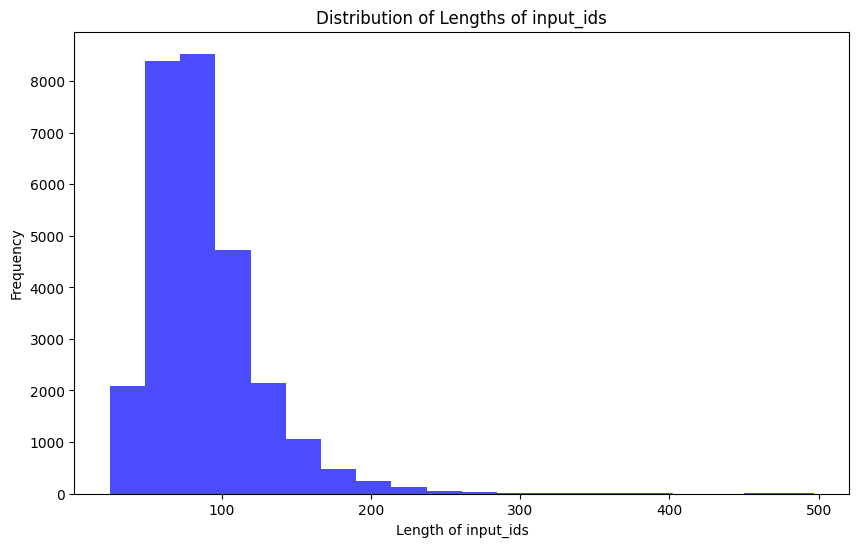

In [57]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).

In [58]:
max_length = 500 # This was an appropriate max length for my dataset

# redefine the tokenize function and tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False, # needed for now, should be fixed soon
)
tokenizer.pad_token = tokenizer.eos_token


def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [65]:
tokenized_train_dataset = dataset['train'].map(generate_and_tokenize_prompt)
tokenized_val_dataset = dataset['validation'].map(generate_and_tokenize_prompt)

  0%|          | 0/23467 [00:00<?, ?ex/s]

  0%|          | 0/4423 [00:00<?, ?ex/s]

In [66]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[4]['input_ids'])
print(untokenized_text)

<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|

Now all the samples should be the same length, `max_length` (320 for me).

27890


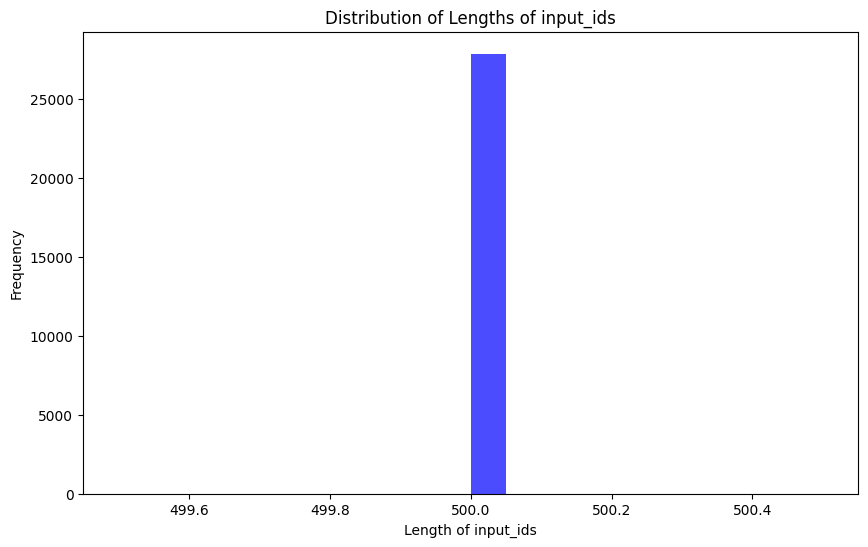

In [67]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

#### How does the base model do?

Let's grab a test input (`meaning_representation`) and desired output (`target`) pair to see how the base model does on it.

In [70]:
print("Target Sentence: " + dataset['test'][1]['text'])
print("Keywords: " + dataset['test'][1]['keywords'] + "\n")

Target Sentence: Could the benefits received by my family be affected if my widow receives a pension based on work?
If it not covered by Social Security, her benefits as a survivor may be affected.
Keywords: pension, widow, benefits, survivor, family



In [71]:
eval_prompt = f"""From given dialogue extract 4 or 5 key words 
### Dialogue: Could the benefits received by my family be affected if my widow receives a pension based on work?
If it not covered by Social Security, her benefits as a survivor may be affected.
### Keywords:
"""

In [74]:
# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

In [75]:
# Re-init the tokenizer so it doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [76]:
device = "cuda"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to(device)

In [77]:
model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=128)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


From given dialogue extract 4 or 5 key words 
### Dialogue: Could the benefits received by my family be affected if my widow receives a pension based on work?
If it not covered by Social Security, her benefits as a survivor may be affected.
### Keywords:
benefits, family, widow, pension, Social Security



We can see it doesn't do very well out of the box.

### 6. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. Let's set up our LoRA layers.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to some linear layers of the model. Those layers are `Wqkv`, `fc1`, `fc2`.

In [ ]:
print(model)

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=8` and `lora_alpha=16` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "Wqkv",
        "fc1",
        "fc2",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

See how the model looks different now, with the LoRA adapters added:

In [ ]:
print(model)

### 7. Run Training!

I used only 500 steps for the sake of getting this notebook out (it took about an hour), but I found the model should have trained for longer as it had not converged by then, so I upped the steps to 1000 below. It may even need longer.

A note on training. You can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting - the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`phi2-finetune-viggo`) as your final model in step 8 below.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "viggo-finetune"
base_model_name = "phi2"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        max_steps=1000,
        learning_rate=2.5e-5,
        logging_steps=25,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

I cleared the output of the cell above because I stopped the training early, and it produced a long, ugly error message.

### 8. Drum Roll... Try the Trained Model!

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`).

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base Phi-2 model from the Huggingface Hub:


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    load_in_8bit=True,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16,
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False,
)

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "phi2-viggo-finetune/checkpoint-500")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better.

In [ ]:
eval_prompt = """Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:
"""

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))